In [43]:
import pandas as pd
import scanpy as sc

# Format the AnnData object

## Basic modifications

In [44]:
adata = sc.read_h5ad("../scrnaseq/run/star_plate/star/mtx_conversions/combined_raw_matrix.h5ad")

# nf-core/scrnaseq adds these columns to the obs dataframe, but they are not useful for us
adata.obs = adata.obs.drop(columns=["fastq_1", "fastq_2"])

# Add column for sample type
adata.obs["is_rr"] = adata.obs["sample"].str.contains("RR")

# Extract the barcode from the cell name
adata.obs["barcode"] = adata.obs.index.str.split("_").str[0]

# Convert the count matrix to int32
adata.layers["count"] = adata.layers["count"].astype("int32")
adata.X = adata.layers["count"]

# By default, the var names are the gene IDs
# Gene names are generally easier to interpret, so we will use the gene names as the var names
# In some cases this will result in duplicate var names, but here this is not a problem
adata.var_names = adata.var["gene_symbol"].str.upper()

# Saving the anndata object fails if the index name also exists as a column
adata.var.index.name = "gene_name"

adata

AnnData object with n_obs × n_vars = 11520 × 78239
    obs: 'sample', 'is_rr', 'barcode'
    var: 'gene_ids', 'feature_types', 'gene_symbol', 'gene_versions'
    layers: 'ambiguous', 'count', 'spliced', 'unspliced'

## Identify the cell types

We were provided with a mapping from the cell position to the cell type.
Thus, we first need to map the barcodes to the positions in the matrix and then map the positions to the cell types.

In [45]:
df_bc_pos = pd.read_csv("../data/reference/plate_position.tsv", sep="\t", index_col=1)
bc_pos = df_bc_pos.to_dict()["Position"]

adata.obs["well_position"] = adata.obs["barcode"].map(bc_pos)

# well_position looks like "A11"
adata.obs["well_row"] = adata.obs["well_position"].str[0]
adata.obs["well_column"] = adata.obs["well_position"].str[1:].astype(int)

# Columns 0-11 are 2CLC, columns 12-23 are mESC
adata.obs["cell_type"] = adata.obs["well_column"].apply(lambda x: "mESC" if x > 11 else "2CLC")

# Quality control

In [46]:
# All human mitochondrial genes start with "mt-"
adata.var["mt"] = adata.var["gene_symbol"].str.startswith("mt-")

sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], inplace=True, log1p=True, layer="count"
)

## Raw QC plots

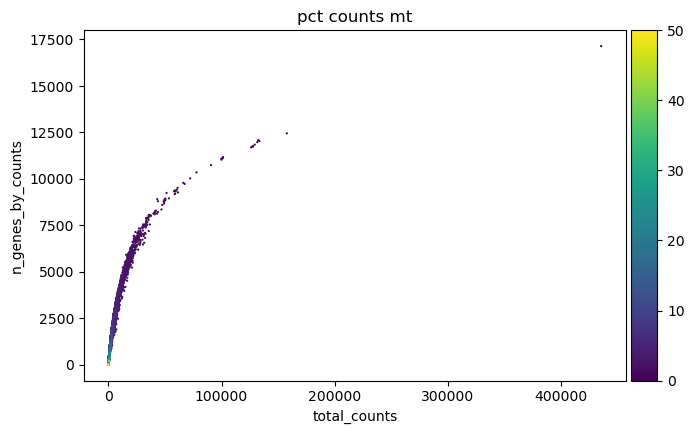

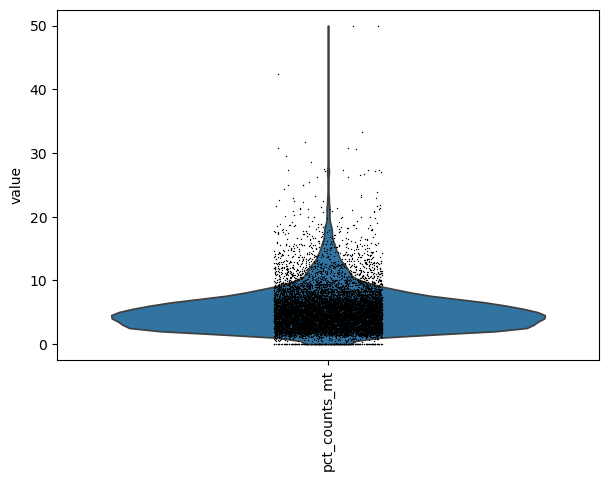

In [47]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")
sc.pl.violin(adata, "pct_counts_mt", rotation=90)

## Filtering

Thresholds were estimated based on the raw QC plots.
Can be adjusted if needed.

In [48]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)
adata = adata[adata.obs["pct_counts_mt"] < 12, :].copy()
adata

AnnData object with n_obs × n_vars = 9535 × 27521
    obs: 'sample', 'is_rr', 'barcode', 'well_position', 'well_row', 'well_column', 'cell_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'gene_ids', 'feature_types', 'gene_symbol', 'gene_versions', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    layers: 'ambiguous', 'count', 'spliced', 'unspliced'

## Filtered QC plots

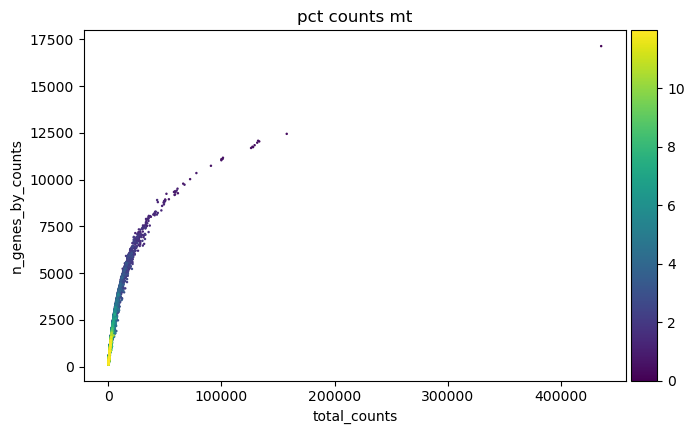

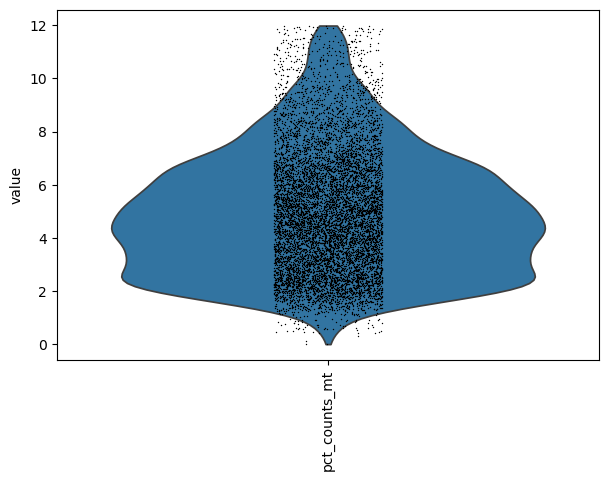

In [49]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")
sc.pl.violin(adata, "pct_counts_mt", rotation=90)

In [50]:
sc.pp.scrublet(adata, batch_key="sample")
adata.obs["predicted_doublet"].value_counts()

predicted_doublet
False    8372
True     1163
Name: count, dtype: int64

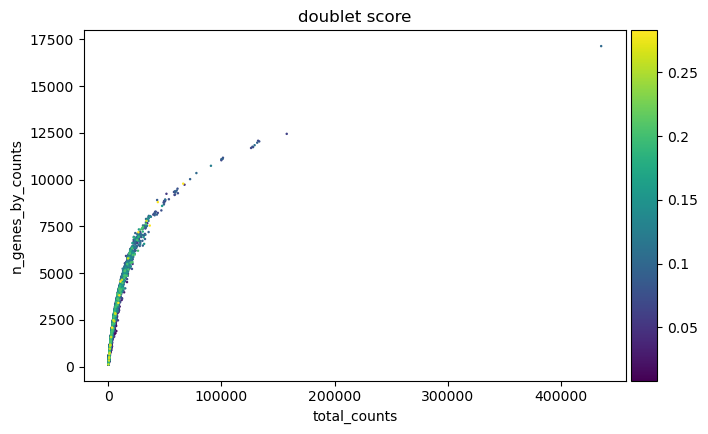

In [51]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="doublet_score")

In [52]:
adata = adata[~adata.obs["predicted_doublet"], :].copy()

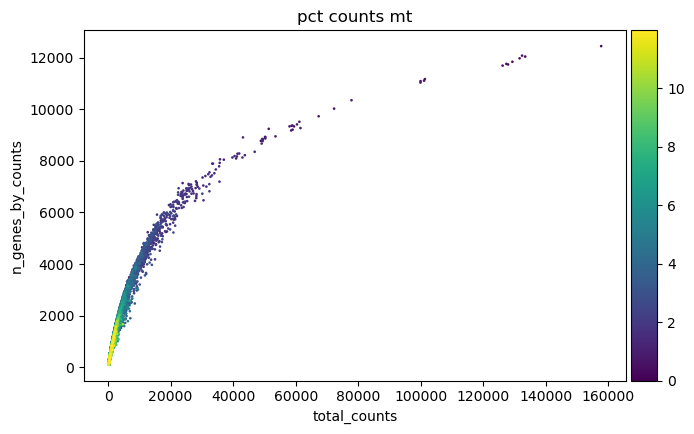

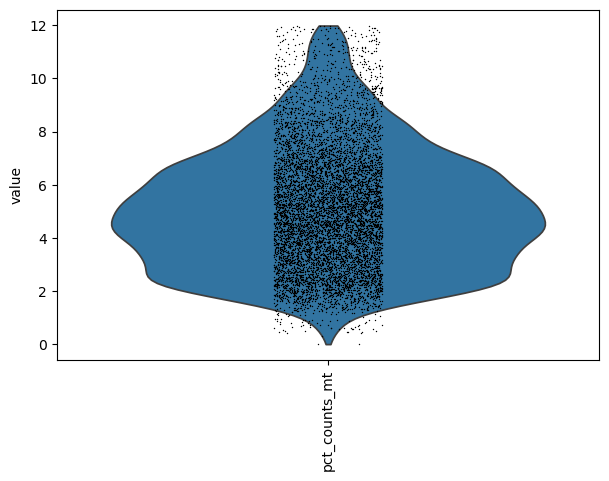

In [53]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")
sc.pl.violin(adata, "pct_counts_mt", rotation=90)

# Normalization

These steps update adata.X

In [54]:
# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)

# Finalize and save

In [55]:
# Make a copy of the log-transformed data
# It is always good to store alternative representations of count data with explicit names
# It is easy to forget what adata.X contains at a later point
adata.layers["log1p"] = adata.X.copy()
adata

AnnData object with n_obs × n_vars = 8372 × 27521
    obs: 'sample', 'is_rr', 'barcode', 'well_position', 'well_row', 'well_column', 'cell_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'feature_types', 'gene_symbol', 'gene_versions', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'scrublet', 'log1p'
    layers: 'ambiguous', 'count', 'spliced', 'unspliced', 'log1p'

In [56]:
adata.write_h5ad("1_qc.h5ad")